In [1]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os

# import matplotlib.pyplot as plt
import tesserocr
from tesserocr import PyTessBaseAPI, RIL
import pytesseract
from IPython.display import HTML
import easyocr
import numpy as np

# from paddleocr import PaddleOCR

In [2]:
MANGA_IMAGES_DIR = r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manga\shinju_no_necktar\chapter_0085"
MANHUA_IMAGES_DIR = r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manhua\my_harem_grew_so_large\chapter_0001"
manga_images = os.listdir(MANGA_IMAGES_DIR)
manga_images_sorted = sorted(manga_images)
manhua_images = os.listdir(MANHUA_IMAGES_DIR)
manhua_images_sorted = sorted(manhua_images)
print("Manga Images in Sorted Order:\n", manga_images_sorted, "\n\n")
print("Manhua Images in Sorted Order:\n", manhua_images_sorted, "\n\n")

Manga Images in Sorted Order:
 ['000001-66228d3b84417.jpg', '000002-66228d3bf2943.jpg', '000003-66228d3c5aabf.jpg', '000004-66228d3cc2d25.jpg', '000005-66228d3d3c3bb.jpg', '000006-66228d3e4867b.jpg', '000007-66228d3ea607f.jpg', '000008-66228d3f18b74.jpg', '000009-66228d3f86ce0.jpg', '000010-66228d3ff178b.jpg', '000011-66228d4068ea1.jpg', '000012-66228d40d8238.jpg', '000013-66228d413cc26.jpg', '000014-66228d41eb36a.jpg', '000015-66228d42618f9.jpg', '000016-66228d4304b9d.jpg', '000017-66228d43e3baf.jpg', '000018-66228d446ca28.jpg', '000019-66228d45515d9.jpg', '000020-66228d4652066.jpg', '000021-66228d4775e96.jpg', '000022-66228d47f2f86.jpg', '000023-66228d48cbb06.jpg', '000024-66228d49555f8.jpg', '000025-66228d49dcbc0.jpg', '000026-66228d4a57dd5.jpg', '000027-66228d4ad3bae.jpg', '000028-66228d4b56a0b.jpg', '000029-66228d4c2fa21.jpg', '000030-66228d4d2b01b.jpg'] 


Manhua Images in Sorted Order:
 ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.

In [3]:
def preprocess_image(img):
    img = (
        img.convert("L")
        .resize([3 * _ for _ in img.size], Image.BICUBIC)
        .point(lambda p: p > 75 and p + 100)
    )
    return img

    # # Apply a binary threshold
    # threshold = 128
    # binary_img = img.point(lambda p: 255 if p > threshold else 0)

    # return binary_img

    # # Convert to grayscale
    # img = img.convert("L")

    # # Apply a median filter for noise reduction
    # img = img.filter(ImageFilter.MedianFilter(size=3))

    # # Enhance contrast
    # enhancer = ImageEnhance.Contrast(img)
    # img = enhancer.enhance(2)  # Adjust this value as needed

    # # Apply binary thresholding
    # img = img.point(lambda p: 255 if p > 128 else 0)

    # # Convert to numpy array for morphological operations
    # img_np = np.array(img)

    # # Apply dilation and erosion (morphological operations)
    # img_np = ImageOps.invert(
    #     Image.fromarray(img_np)
    # )  # Invert colors for morphological operations
    # img_np = img_np.filter(ImageFilter.MinFilter(3))  # Dilation
    # img_np = img_np.filter(ImageFilter.MaxFilter(3))  # Erosion

    # # Convert back to binary
    # img_np = ImageOps.invert(img_np)
    # img_np = img_np.point(lambda p: 255 if p > 128 else 0)

    # # Convert back to PIL image
    # processed_img = Image.fromarray(np.array(img_np))

    # return processed_img


def pil_to_cv2(img):
    # Convert the PIL image to RGB mode (assuming it's not already)
    rgb_image = img.convert("RGB")
    # Get the image data as a NumPy array
    open_cv_image = np.array(rgb_image)

    # Convert color space from RGB (PIL) to BGR (OpenCV)
    return cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)


def drawImage(img, bboxes=[], scalling_factor=1.0, threashold=70.0):
    if img.mode == "L":
        img = img.convert("RGB")
    draw = ImageDraw.Draw(img)
    font_path = os.path.join(r"C:\Windows\Fonts", "simsun.ttc")
    font = ImageFont.truetype(font_path, size=20)
    for box in bboxes:
        x1, y1, x2, y2, text, conf = (
            box["x1"],
            box["y1"],
            box["x2"],
            box["y2"],
            box["text"],
            box["conf"],
        )
        if conf <= threashold:
            continue
        draw.rectangle(((x1, y1), (x2, y2)), outline=(0, 255, 0), width=2)
        draw.text(
            (x1, y1 - 10),
            text,
            font=font,
            fill=(255, 0, 0),
            stroke_width=0,
        )
        draw.text(
            (x1, y1 - 30),
            f"{conf:.0f}",
            font=font,
            fill=(0, 0, 255),
            stroke_width=1,
        )
    display(img.resize(int(scalling_factor * s) for s in img.size))


def drawImageFile(image_path, bboxes=[], scalling_factor=1.0, threashold=70.0):
    image = Image.open(image_path)

    drawImage(image, bboxes, scalling_factor, threashold)


def use_tessorocr(image_path, lang="eng", do_preprocess=False):
    img = Image.open(image_path)
    if do_preprocess:
        img = preprocess_image(image_path)

    # print(tesserocr.image_to_text(img, lang=lang))
    with PyTessBaseAPI(lang=lang) as api:  # type:ignore
        api.SetImage(img)

        print(api.GetUTF8Text())
        print(api.AllWordConfidences())
        regions = api.GetRegions()
        boxes = api.GetComponentImages(RIL.TEXTLINE, True)
        print("regions\n\n")
        for i in regions:
            display(i[0])
        print("\n\nboxes\n\n")
        print(boxes, "\n\n")
        for i in boxes:
            display(i[0])


def use_pytesseract(
    image_path,
    lang="eng",
    config="--oem 1 --psm 3",
    scalling_factor=1.0,
    threashold=70.0,
    do_preprocess=False,
):

    img = Image.open(image_path)
    if do_preprocess:
        img = preprocess_image(img)

    ocr_text = pytesseract.image_to_string(img, lang=lang, config=config)

    print("Text Output: \n\n------------\n", ocr_text, "\n")
    data = pytesseract.image_to_data(img, lang=lang, config=config).split("\n")[1:]
    temp_boxes = []
    for d in data:
        tmp_d = d.split("\t")
        if len(tmp_d) > 1:
            temp_boxes.append(
                {
                    "level": int(tmp_d[0]),
                    "page_num": int(tmp_d[1]),
                    "block_num": int(tmp_d[2]),
                    "par_num": int(tmp_d[3]),
                    "line_num": int(tmp_d[4]),
                    "word_num": int(tmp_d[5]),
                    "x1": int(tmp_d[6]),
                    "y1": int(tmp_d[7]),
                    "x2": int(tmp_d[6]) + int(tmp_d[8]),
                    "y2": int(tmp_d[7]) + int(tmp_d[9]),
                    "width": int(tmp_d[8]),
                    "height": int(tmp_d[9]),
                    "conf": float(tmp_d[10]) if tmp_d[10] else 0.0,
                    "text": tmp_d[11],
                }
            )
    drawImage(img, temp_boxes, scalling_factor, threashold)


def use_EasyOCR(
    image_path, lang, scalling_factor=1.0, threashold=70.0, do_preprocess=False
):
    img = Image.open(image_path)
    if do_preprocess:
        img = preprocess_image(img)
    reader = easyocr.Reader(["en", lang])
    data = reader.readtext(np.array(img) if img.mode == "L" else img)
    tmp_text = ""
    tmp_boxes = []
    for box in data:
        tmp_data = {}
        tmp_coords, text, conf = box
        if len(tmp_coords) > 3:
            x1, y1, x2, y2 = (
                tmp_coords[0][0],
                tmp_coords[0][1],
                tmp_coords[2][0],
                tmp_coords[2][1],
            )
            tmp_data["x1"], tmp_data["y1"], tmp_data["x2"], tmp_data["y2"] = (
                x1,
                y1,
                x2,
                y2,
            )
        tmp_data["text"] = text
        tmp_data["conf"] = conf * 100
        tmp_boxes.append(tmp_data)
        tmp_text += text + "\n"
    print("\n Extracted Text:\n\n", tmp_text)
    drawImage(
        img, bboxes=tmp_boxes, scalling_factor=scalling_factor, threashold=threashold
    )


# def use_PaddleOCR(
#     image_path, lang, scalling_factor=1.0, threashold=70.0, do_preprocess=False
# ):
#     img = Image.open(image_path)
#     if do_preprocess:
#         img = preprocess_image(img)
#     ocr = PaddleOCR(use_angle_cls=True, lang="en")
#     data = ocr.ocr(np.array(img) if img.mode == "L" else img)
#     print(data)
#     return
#     tmp_text = ""
#     tmp_boxes = []
#     for box in data:
#         tmp_data = {}
#         tmp_coords, text, conf = box
#         if len(tmp_coords) > 3:
#             x1, y1, x2, y2 = (
#                 tmp_coords[0][0],
#                 tmp_coords[0][1],
#                 tmp_coords[2][0],
#                 tmp_coords[2][1],
#             )
#             tmp_data["x1"], tmp_data["y1"], tmp_data["x2"], tmp_data["y2"] = (
#                 x1,
#                 y1,
#                 x2,
#                 y2,
#             )
#         tmp_data["text"] = text
#         tmp_data["conf"] = conf * 100
#         tmp_boxes.append(tmp_data)
#         tmp_text += text + "\n"
#     print("\n Extracted Text:\n\n", tmp_text)
#     drawImage(
#         img, bboxes=tmp_boxes, scalling_factor=scalling_factor, threashold=threashold
#     )

符 剑 双 修 , . 年 纪
轻 轻 就 晋 入


[95, 96, 96, 96, 90, 89, 96, 87, 96, 96, 97, 93, 90, 95, 95]
regions




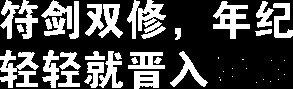

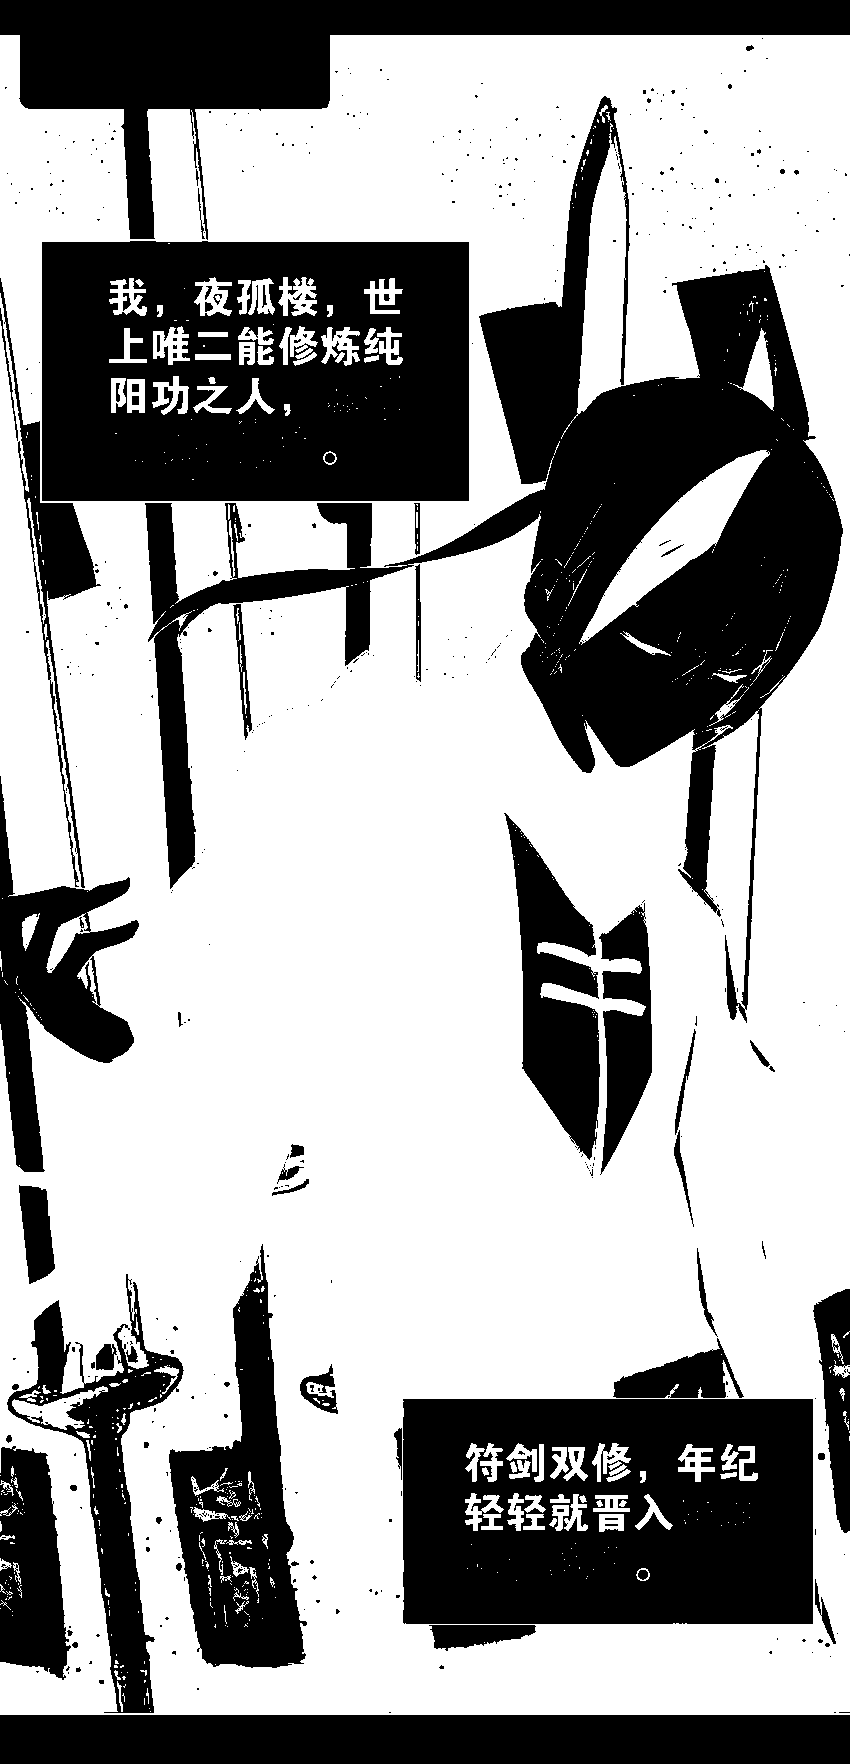



boxes


[(<PIL.BmpImagePlugin.BmpImageFile image mode=L size=293x40 at 0x2487FE60650>, {'x': 465, 'y': 1443, 'w': 293, 'h': 40}, 0, None), (<PIL.BmpImagePlugin.BmpImageFile image mode=L size=208x39 at 0x2487FE629C0>, {'x': 465, 'y': 1493, 'w': 208, 'h': 39}, 0, None)] 




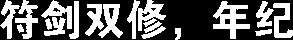

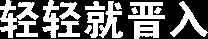

In [4]:
img_idx = 6
mode = "manhua"
ocr_tool = "easyocr"
LANG = "eng"
if mode == "manhua":
    if ocr_tool == "easyocr":
        LANG = "ch_sim"
    elif ocr_tool == "tesseract":
        LANG = "chi_sim"
elif mode == "manga":
    if ocr_tool == "easyocr":
        LANG = "ja"
    elif ocr_tool == "tesseract":
        LANG = "jpn"

image_path = (
    os.path.join(MANHUA_IMAGES_DIR, manhua_images_sorted[img_idx])
    if mode == "manhua"
    else os.path.join(MANGA_IMAGES_DIR, manga_images_sorted[img_idx])
)
use_tessorocr(image_path, lang="chi_sim")
# use_pytesseract(image_path, lang=LANG, config="--oem 1 --psm 6", threashold=50.0)
# use_EasyOCR(
#     image_path, lang=LANG, threashold=0.0, scalling_factor=1.0, do_preprocess=False
# )

# use_PaddleOCR(
#     image_path, lang=LANG, threashold=0.0, scalling_factor=1.0, do_preprocess=False
# )

In [5]:
# import os


# def prepend_zeros(filename: str, char_to_extract_num: str = ".") -> str:
#     numeric_part, rest = filename.split(char_to_extract_num, 1)
#     # Convert the numeric part to an integer
#     num = int(numeric_part)

#     # Format the numeric part to have exactly 6 digits with leading zeros
#     new_numeric_part = f"{num:06d}"

#     # Construct the new filename
#     new_filename = f"{new_numeric_part}{char_to_extract_num}{rest}"
#     return new_filename


# def rename_images_in_folder(folder, char_to_extract_num="."):
#     for filename in os.listdir(folder):
#         # Check if it's an image file
#         if os.path.isfile(os.path.join(folder, filename)) and filename.lower().endswith(
#             (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
#         ):
#             # Generate new filename with sequence number
#             new_filename = prepend_zeros(filename, char_to_extract_num)
#             source = os.path.join(folder, filename)
#             destination = os.path.join(folder, new_filename)
#             # Rename the file
#             os.rename(source, destination)
#             print(f"{filename}  ->   {new_filename}")


# rename_images_in_folder(
#     r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manga\shinju_no_necktar\chapter_0085",
#     "-",
# )
# rename_images_in_folder(
#     r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manhua\my_harem_grew_so_large\chapter_0001",
#     ".",
# )

In [6]:
# import glob
# from PIL import Image

# image_paths = glob.iglob("sampleImages/manhua/*/*/*", recursive=True)
# # for image_path in image_paths:
# #     print(image_path)
# print(next(image_paths))
# img = Image.open(next(image_paths))
# print(img.mode)
# img = img.convert("RGB")
# print(img.mode)